<a href="https://colab.research.google.com/github/jinhqian/L645_project/blob/main/glove/Hate_Speech_Detection_using_deep_learning__glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Dataset**

### 1.1 Load the dataset

In [ ]:
# load the data
import pandas as pd
dataset = pd.read_csv("/content/drive/MyDrive/L645/data/labeled_data.csv")

### 1.2 Data analysis

In [ ]:
# Number of tweets that are annotated as hate-speech
print(sum(dataset['class'] == 0))

# Number of tweets that are annotated as offensive language
print(sum(dataset['class'] == 1))

# Number of tweets that are annotated as neither hate-speech nor offensive
print(sum(dataset['class'] == 2))

# # Check if there are any null values in the dataset
dataset.isna().sum()

1430
19190
4163


Index                 0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

### 1.3 Data visualization

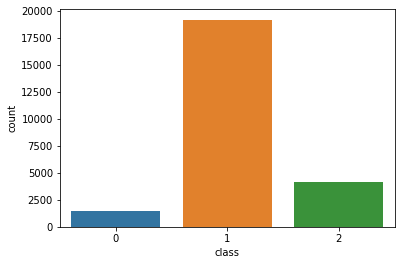

In [ ]:
# 0 for hate speech
# 1 for offensive language
# 2 for neither hate-speech nor offensive

import seaborn as sns
sns.countplot(x = 'class', data = dataset)

# **2. Data preprocessing**

### 2.1 Data cleaning

In [ ]:
import nltk, re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stop_words = stopwords.words('english')
stop_words_dict = Counter(stop_words)
contract_patterns = [(r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'be not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                        (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it')]

# Replace contractions from tweets
def replace_contraction(text):
    patterns = [(re.compile(regex), rpl) for (regex, rpl) in contract_patterns]
    for (pattern, rpl) in patterns:
        (text, count) = re.subn(pattern, rpl, text)
    return text

# Clean the tweets by removing and replacing the unrequired characters
def clean_tweets(tweet):
    tweet = re.sub(r' RT ', ' ', tweet) # Remove RT
    tweet = re.sub(r'http\S+', 'url', tweet) # Replaces url address with "url"
    tweet = re.sub(r'@[^\s]+','atusername',tweet) # Replaces "@user" with "atusername"
    tweet = re.sub(r'#[^\s]+', ' ', tweet) # Removes hastag in front of a word 
    tweet = re.sub(r'[^\w\s]', ' ', tweet) # Remove everything except characters and whitespace
    tweet = re.sub(r'[^a-zA-Z] ', ' ', tweet) # Remove numbers
    tweet = re.sub(r'\s\s+', ' ', tweet) # Remove multiple spaces
    tweet = tweet.lower() # Convert each character to lower case and remove spaces around them
    return tweet

# Removes stop words
def remove_stop_words(tweet):
    tokens = word_tokenize(tweet)
    tokens = [word for word in tokens if word not in stop_words_dict]
    return ' '.join(tokens)

# Replace contractions in the tweets
dataset["tweet"] = dataset.tweet.apply(replace_contraction)

# Clean the tweets
dataset["tweet"] = dataset.tweet.apply(clean_tweets)

# Remove stop words in the tweets
dataset['tweet'] = dataset.tweet.apply(remove_stop_words)

print(dataset['tweet'])

0        atusername woman complain cleaning house andam...
1        atusername boy dats cold tyga dwn bad cuffin d...
2        atusername dawg atusername ever fuck bitch sta...
3                   atusername atusername look like tranny
4        atusername shit hear might true might faker bi...
                               ...                        
24778    muthaf lie atusername atusername right tl tras...
24779      gone broke wrong heart baby drove redneck crazy
24780    young buck wan na eat dat nigguh like aint fuc...
24781                    youu got wild bitches tellin lies
24782    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 24783, dtype: object


### 2.2 Lemmatization or Stemming

In [ ]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Lemmatization
def lemmatize_tweets(tweet):
    tokens = word_tokenize(tweet)
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Stemming
def stemming_tweets(tweet):
    tokens = word_tokenize(tweet)
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# Create word representation
def word_representation(dataset, type = 'lemmatization'):
    if type == 'lemmatization':
        dataset['tweet'] = list(map(lemmatize_tweets, dataset['tweet']))
    else:
        dataset['tweet'] = list(map(stemming_tweets, dataset['tweet']))
    return dataset

dataset = word_representation(dataset)
dataset["tweet"]

0        atusername woman complain cleaning house andam...
1        atusername boy dat cold tyga dwn bad cuffin da...
2        atusername dawg atusername ever fuck bitch sta...
3                   atusername atusername look like tranny
4        atusername shit hear might true might faker bi...
                               ...                        
24778    muthaf lie atusername atusername right tl tras...
24779      gone broke wrong heart baby drove redneck crazy
24780    young buck wan na eat dat nigguh like aint fuc...
24781                       youu got wild bitch tellin lie
24782    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 24783, dtype: object

# **3. Sequence Data Transformation**

### 3.1 Spliting the dataset into train and test set

In [ ]:
# Split the train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['tweet'], dataset['class'], random_state = 42, test_size=0.1, shuffle = True)

### 3.2 Data preparation using tokenization, data sequence preparation, padding for equal length sequence.

In [ ]:
# Define Hyperparameters
VOCABULARY_SIZE = 2000
MAX_LENGTH = 60

# Tokenization
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, oov_token = '<OOV>')
tokenizer.fit_on_texts(list(X_train) + list(X_test))

# Save the toeknizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Sequences
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

# Padding
from keras_preprocessing.sequence import pad_sequences
X_train_padding = pad_sequences(X_train_sequence, maxlen = MAX_LENGTH, padding = 'post', truncating = 'post')
X_test_padding = pad_sequences(X_test_sequence, maxlen = MAX_LENGTH, padding = 'post', truncating = 'post')

word_index = tokenizer.word_index

### 3.3 Sequence representation using word embeddings (GloVe, Word2Vec, and Paragram)

### 3.3.1 Golve

In [ ]:
from tqdm import tqdm
import numpy as np
glove_embeddings_index = {}
f = open('/content/drive/MyDrive/L645/data/glove.6B.100d.txt', encoding='utf8') #100d

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    glove_embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_embeddings_index))


400000it [00:09, 40302.30it/s]

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index)+ 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 17815/17815 [00:00<00:00, 574869.41it/s]


### 3.3.2 Word2Vec

In [ ]:
# from tqdm import tqdm
# import numpy as np
# W2V_embeddings_index = {}
# f = open('/content/drive/MyDrive/L645/data/word2vec.txt', encoding='utf8')  #100d

# for line in tqdm(f):
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:],dtype='float32')
#     W2V_embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(W2V_embeddings_index))

In [ ]:
# embedding_matrix = np.zeros((len(word_index)+ 1, 100))
# for word, i in tqdm(word_index.items()):
#     embedding_vector = W2V_embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

### 3.3.3 Paragram

In [ ]:
# from tqdm import tqdm
# import numpy as np
# P_embeddings_index = {}
# f = open('/content/drive/MyDrive/L645/data/paragram_300_sl999.txt', encoding='utf8')  #300d

# for line in tqdm(f):
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:])
#     P_embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(P_embeddings_index))

In [ ]:
# embedding_matrix = np.zeros((len(word_index)+ 1, 300))
# for word, i in tqdm(word_index.items()):
#     embedding_vector = P_embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

# **4. Building models**

In [ ]:
# binarize the labels for the neural network
from keras.utils import np_utils
from keras.models import Sequential
from tensorflow.keras.layers import Embedding
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras import layers
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import SpatialDropout1D, Bidirectional
from keras.layers.core import Dense, Activation, Dropout

y_train_encode = np_utils.to_categorical(y_train)
y_test_encode = np_utils.to_categorical(y_test)

### 4.1 Simple RNN

In [ ]:
# Build the RNN model
def build_RNN_model():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, 100, weights = [embedding_matrix], input_length = MAX_LENGTH, trainable = False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(SimpleRNN(100, dropout = 0.2, recurrent_dropout=0.2)))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [ ]:
# Train the model
model_rnn = build_RNN_model()
history_rnn = model_rnn.fit(X_train_padding, y=y_train_encode, batch_size=512, epochs=15, verbose=1, validation_data=(X_test_padding, y_test_encode))

Epoch 1/15
44/44 [==============================] - 12s 171ms/step - loss: 0.7531 - accuracy: 0.7089 - val_loss: 0.5680 - val_accuracy: 0.7838
Epoch 2/15
44/44 [==============================] - 7s 164ms/step - loss: 0.5582 - accuracy: 0.7973 - val_loss: 0.5051 - val_accuracy: 0.8302
Epoch 3/15
44/44 [==============================] - 7s 162ms/step - loss: 0.5015 - accuracy: 0.8199 - val_loss: 0.4405 - val_accuracy: 0.8483
Epoch 4/15
44/44 [==============================] - 7s 166ms/step - loss: 0.4764 - accuracy: 0.8313 - val_loss: 0.4408 - val_accuracy: 0.8491
Epoch 5/15
44/44 [==============================] - 7s 164ms/step - loss: 0.4587 - accuracy: 0.8371 - val_loss: 0.4315 - val_accuracy: 0.8471
Epoch 6/15
44/44 [==============================] - 7s 164ms/step - loss: 0.4473 - accuracy: 0.8425 - val_loss: 0.4053 - val_accuracy: 0.8516
Epoch 7/15
44/44 [==============================] - 7s 164ms/step - loss: 0.4415 - accuracy: 0.8395 - val_loss: 0.4128 - val_accuracy: 0.8524
Epoch

### 4.2 LSTM

In [ ]:
# Build LSTM model

def build_LSTM_model():
    model = Sequential()
    # model.add(Embedding(len(word_index) + 1, 100, weights = [embedding_matrix], input_length = MAX_LENGTH, trainable = False))
    model.add(Embedding(len(word_index) + 1, 100, weights = [embedding_matrix], input_length = MAX_LENGTH, trainable = False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(100, dropout = 0.2, recurrent_dropout=0.2)))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [ ]:
# Train the model
model_lstm = build_LSTM_model()
history_lstm = model_lstm.fit(X_train_padding, y=y_train_encode, batch_size=512, epochs=15, verbose=1, validation_data=(X_test_padding, y_test_encode))

Epoch 1/15
44/44 [==============================] - 29s 556ms/step - loss: 0.6218 - accuracy: 0.7791 - val_loss: 0.4472 - val_accuracy: 0.8536
Epoch 2/15
44/44 [==============================] - 22s 503ms/step - loss: 0.4166 - accuracy: 0.8502 - val_loss: 0.3861 - val_accuracy: 0.8588
Epoch 3/15
44/44 [==============================] - 22s 509ms/step - loss: 0.3675 - accuracy: 0.8605 - val_loss: 0.3452 - val_accuracy: 0.8665
Epoch 4/15
44/44 [==============================] - 27s 621ms/step - loss: 0.3377 - accuracy: 0.8704 - val_loss: 0.3272 - val_accuracy: 0.8717
Epoch 5/15
44/44 [==============================] - 22s 504ms/step - loss: 0.3263 - accuracy: 0.8734 - val_loss: 0.3200 - val_accuracy: 0.8762
Epoch 6/15
44/44 [==============================] - 32s 739ms/step - loss: 0.3182 - accuracy: 0.8763 - val_loss: 0.3148 - val_accuracy: 0.8737
Epoch 7/15
44/44 [==============================] - 23s 504ms/step - loss: 0.3086 - accuracy: 0.8818 - val_loss: 0.3135 - val_accuracy: 0.8790

### 4.3 GRU

In [ ]:
# Build GRU model
def build_GRU_model():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, 100, weights = [embedding_matrix], input_length = MAX_LENGTH, trainable = False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(GRU(100, dropout = 0.2, recurrent_dropout=0.2)))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [ ]:
# Train the model
model_gru = build_GRU_model()
history_gru = model_gru.fit(X_train_padding, y=y_train_encode, batch_size=512, epochs=15, verbose=1, validation_data=(X_test_padding, y_test_encode))

Epoch 1/15
44/44 [==============================] - 24s 458ms/step - loss: 0.6271 - accuracy: 0.7655 - val_loss: 0.4558 - val_accuracy: 0.8503
Epoch 2/15
44/44 [==============================] - 20s 455ms/step - loss: 0.4073 - accuracy: 0.8550 - val_loss: 0.3715 - val_accuracy: 0.8657
Epoch 3/15
44/44 [==============================] - 21s 475ms/step - loss: 0.3576 - accuracy: 0.8680 - val_loss: 0.3397 - val_accuracy: 0.8681
Epoch 4/15
44/44 [==============================] - 20s 456ms/step - loss: 0.3338 - accuracy: 0.8710 - val_loss: 0.3263 - val_accuracy: 0.8745
Epoch 5/15
44/44 [==============================] - 20s 455ms/step - loss: 0.3235 - accuracy: 0.8747 - val_loss: 0.3181 - val_accuracy: 0.8737
Epoch 6/15
44/44 [==============================] - 20s 449ms/step - loss: 0.3115 - accuracy: 0.8778 - val_loss: 0.3165 - val_accuracy: 0.8766
Epoch 7/15
44/44 [==============================] - 20s 458ms/step - loss: 0.3070 - accuracy: 0.8808 - val_loss: 0.3103 - val_accuracy: 0.8770

# **5. Module Validation and Evaluation**

In [ ]:
# plot the training and validation accuracy per epoch of a model.
def performance_history(history, model_name, image_path, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.title(model_name + ' ' + string + ' per epoch')
    # Save the figure
    plt.savefig(image_path + model_name + ' ' + string + ' per epoch.png', dpi = 600)
    # Display the figure
    plt.show()

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
# generate the performance report of a model
def performance_report(model, model_name, image_path, testX, testy):

    time = date.today()
    
    yhat_probs=model.predict(testX) 
    yhat_classes = np.argmax(yhat_probs, axis = 1)
    ytest = np.argmax(testy, axis = 1)
    
    accuracy = accuracy_score(ytest, yhat_classes)  # (tp + tn) / (p + n)
    precision = precision_score(ytest, yhat_classes, average = 'macro') # tp / (tp + fp)
    recall = recall_score(ytest, yhat_classes, average = 'macro') # tp / (tp + fn)
    f1 = f1_score(ytest, yhat_classes, average = 'macro') # 2 tp / (2 tp + fp + fn)
    
    # confusion matrix
    cf_matrix = confusion_matrix(ytest, yhat_classes)
    cf_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['Hate', 'Offensive', 'Neither'])
    # plot the confusion matrix
    cf_display.plot()
    # plt.show()
    # save the confusion matrix figure
    plt.savefig(image_path + model_name + ' performance_report.png', dpi=600)
    # figure.savefig(image_path + model_name + ' performance_report.png', dpi=600, transparent=True, bbox_inches='tight')

    total_cost_df = pd.DataFrame(
            columns=['Time', 'Model Name', 'Precision', 'Recall', 'F1 Score', 'Accuracy'])

    total_cost_df = total_cost_df.append(
            {'Time': time, 
             'Precision': precision,
             'Model Name': model_name,
             'Recall': recall, 
             'F1 Score': f1,
             'Accuracy':accuracy},
            ignore_index=True)
    return total_cost_df

In [ ]:
## Create folders to save the models and plot
import os 

image_path = '/content/drive/MyDrive/L645/project/glove/images/'
model_path = '/content/drive/MyDrive/L645/project/glove/'

# Create image and model folder if they don't exist
def create_directry(path):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path)

# Create image path
create_directry(image_path)

# Create model path
create_directry(model_path)

78/78 [==============================] - 1s 10ms/step


,Time,Model Name,Precision,Recall,F1 Score,Accuracy
0,2022-12-11,Simple RNN,0.674852,0.629022,0.592651,0.855587


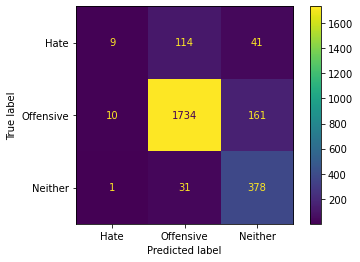

In [ ]:
# Compare models
from datetime import date
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
rnn_report = performance_report(model_rnn, "Simple RNN", image_path, X_test_padding, y_test_encode)
rnn_report

78/78 [==============================] - 3s 32ms/step


,Time,Model Name,Precision,Recall,F1 Score,Accuracy
0,2022-12-11,LSTM,0.761822,0.710427,0.725808,0.888665


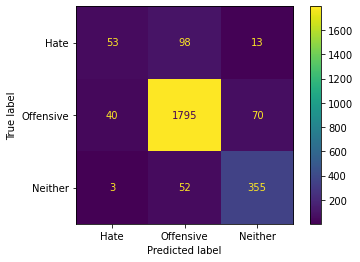

In [ ]:
lstm_report = performance_report(model_lstm, "LSTM", image_path, X_test_padding, y_test_encode)
lstm_report


78/78 [==============================] - 3s 34ms/step


,Time,Model Name,Precision,Recall,F1 Score,Accuracy
0,2022-12-11,GRU,0.732895,0.632981,0.647664,0.879387


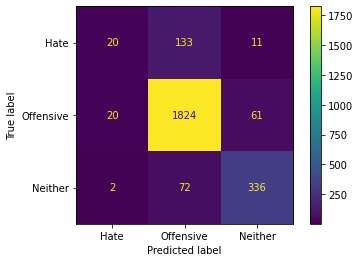

In [ ]:
GRU_report = performance_report(model_gru, "GRU", image_path, X_test_padding, y_test_encode)
GRU_report

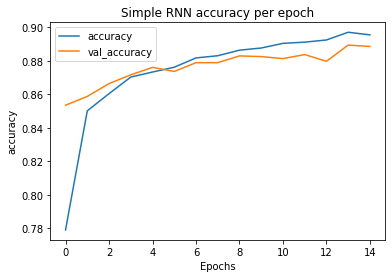

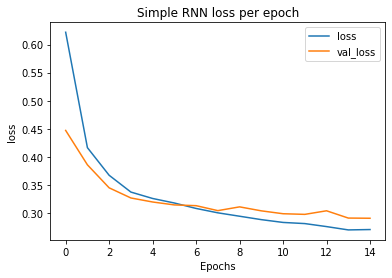

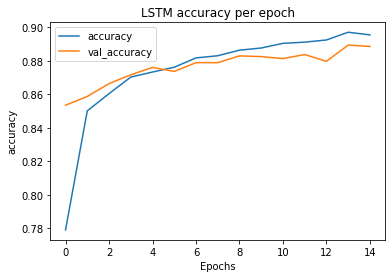

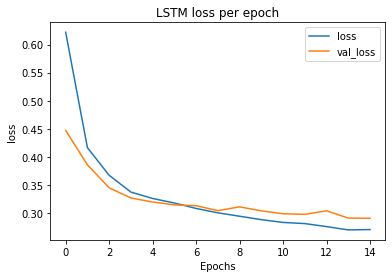

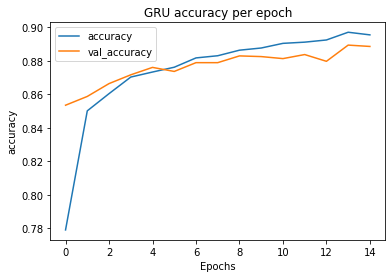

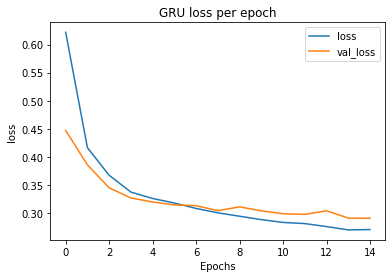

In [ ]:
performance_history(history_lstm, "Simple RNN", image_path, 'accuracy')
performance_history(history_lstm, "Simple RNN", image_path, 'loss')

performance_history(history_lstm, "LSTM", image_path, 'accuracy')
performance_history(history_lstm, "LSTM", image_path, 'loss')

performance_history(history_lstm, "GRU", image_path, 'accuracy')
performance_history(history_lstm, "GRU", image_path, 'loss')



# **6. Add class weight to handel unbalanced dataset**

### 6.1 Calculate class weight using fomula: w_j = n_samples / (n_classes * n_samples_j)
    

In [ ]:
# Total number of samples
n_samples = len(dataset)

# Total number of classes
n_classes = len(pd.unique(dataset['class']))

# Total number of samples in each class
n_sample_0 = sum(dataset['class'] == 0)
n_sample_1 = sum(dataset['class'] == 1)
n_sample_2 = sum(dataset['class'] == 2)

# The weights of each calss
w_0 = n_samples / (n_classes * n_sample_0)
w_1 = n_samples / (n_classes * n_sample_1)
w_2 = n_samples / (n_classes * n_sample_2)

# Class weights
class_weights = {
    0: w_0,
    1: w_1,
    2: w_2
}

class_weights

{0: 5.776923076923077, 1: 0.43048462741010945, 2: 1.9843862599087196}

6.2 Train GRU model with class weight 

In [ ]:
# Train the model
# model_GRU_weighted = build_GRU_model()
# history_GRU_weighted = model_GRU_weighted.fit(X_train_padding, y=y_train_encode, batch_size=512, epochs=15, verbose=1, validation_data=(X_test_padding, y_test_encode), class_weight = class_weights)

Epoch 1/15
44/44 [==============================] - 24s 465ms/step - loss: 0.9651 - accuracy: 0.5771 - val_loss: 0.6230 - val_accuracy: 0.7914
Epoch 2/15
44/44 [==============================] - 20s 444ms/step - loss: 0.6772 - accuracy: 0.7425 - val_loss: 0.5673 - val_accuracy: 0.7947
Epoch 3/15
44/44 [==============================] - 19s 439ms/step - loss: 0.6061 - accuracy: 0.7886 - val_loss: 0.6048 - val_accuracy: 0.7894
Epoch 4/15
44/44 [==============================] - 20s 447ms/step - loss: 0.5761 - accuracy: 0.7839 - val_loss: 0.4971 - val_accuracy: 0.8237
Epoch 5/15
44/44 [==============================] - 21s 482ms/step - loss: 0.5550 - accuracy: 0.7924 - val_loss: 0.5076 - val_accuracy: 0.8084
Epoch 6/15
44/44 [==============================] - 19s 441ms/step - loss: 0.5490 - accuracy: 0.7908 - val_loss: 0.4559 - val_accuracy: 0.8294
Epoch 7/15
44/44 [==============================] - 20s 452ms/step - loss: 0.5384 - accuracy: 0.7936 - val_loss: 0.5535 - val_accuracy: 0.7781

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 100)           1781600   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 60, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              121200    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                

,Time,Model Name,Precision,Recall,F1 Score,Accuracy
0,2022-12-11,Weighted GRU,0.658741,0.827845,0.681948,0.773296


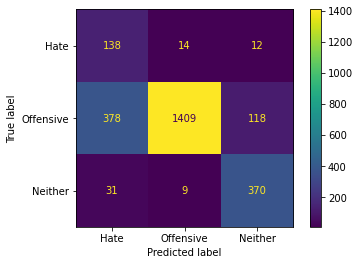

In [ ]:
# model_GRU_weighted.summary()
# performance_report(model_GRU_weighted, "Weighted GRU", image_path, X_test_padding, y_test_encode)

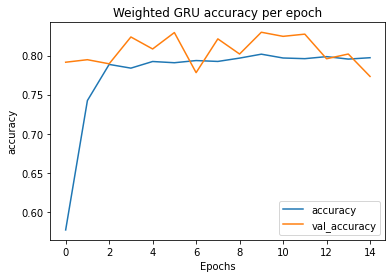

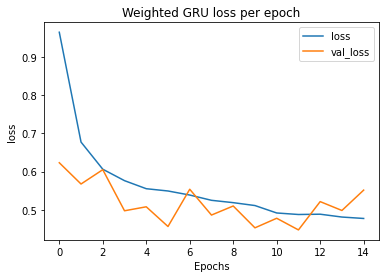

In [ ]:
# Accuracy and loss of weighted LSTM model
# performance_history(history_GRU_weighted, "Weighted GRU", image_path, 'accuracy')
# performance_history(history_GRU_weighted, "Weighted GRU", image_path, 'loss')

In [ ]:
# Train the model
model_lstm_weighted = build_LSTM_model()
history_lstm_weighted = model_lstm_weighted.fit(X_train_padding, y=y_train_encode, batch_size=512, epochs=15, verbose=1, validation_data=(X_test_padding, y_test_encode), class_weight = class_weights)

Epoch 1/15
44/44 [==============================] - 28s 515ms/step - loss: 0.8964 - accuracy: 0.6059 - val_loss: 0.6291 - val_accuracy: 0.7616
Epoch 2/15
44/44 [==============================] - 22s 511ms/step - loss: 0.6886 - accuracy: 0.7392 - val_loss: 0.5175 - val_accuracy: 0.8253
Epoch 3/15
44/44 [==============================] - 23s 518ms/step - loss: 0.6305 - accuracy: 0.7640 - val_loss: 0.5429 - val_accuracy: 0.8108
Epoch 4/15
44/44 [==============================] - 24s 540ms/step - loss: 0.5964 - accuracy: 0.7809 - val_loss: 0.5344 - val_accuracy: 0.8136
Epoch 5/15
44/44 [==============================] - 22s 492ms/step - loss: 0.5721 - accuracy: 0.7896 - val_loss: 0.5072 - val_accuracy: 0.8193
Epoch 6/15
44/44 [==============================] - 22s 494ms/step - loss: 0.5518 - accuracy: 0.7927 - val_loss: 0.4836 - val_accuracy: 0.8225
Epoch 7/15
44/44 [==============================] - 22s 495ms/step - loss: 0.5434 - accuracy: 0.7930 - val_loss: 0.4576 - val_accuracy: 0.8286

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 60, 100)           1781600   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 60, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_4 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 100)               20100     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                

,Time,Model Name,Precision,Recall,F1 Score,Accuracy
0,2022-12-11,Weighted LSTM,0.668716,0.809083,0.711077,0.826543


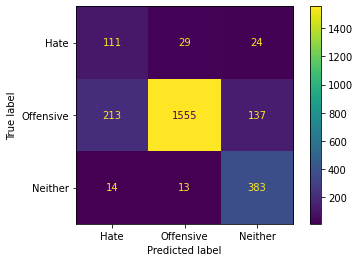

In [ ]:
model_lstm_weighted.summary()
performance_report(model_lstm_weighted, "Weighted LSTM", image_path, X_test_padding, y_test_encode)

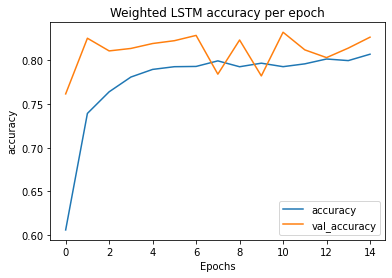

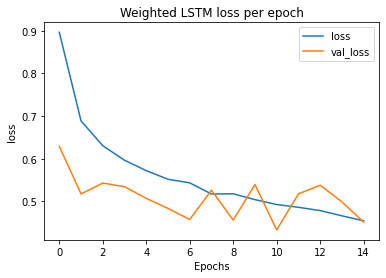

In [ ]:
# Accuracy and loss of weighted LSTM model
performance_history(history_lstm_weighted, "Weighted LSTM", image_path, 'accuracy')
performance_history(history_lstm_weighted, "Weighted LSTM", image_path, 'loss')

### 6.3 Save the models

In [ ]:
def save_model(model, model_name, model_path):
    model.save(model_path + model_name)

In [ ]:
save_model(model_rnn, "Simple_RNN_Model", model_path)
save_model(model_lstm, "LSTM_Model", model_path)
save_model(model_gru, "GRU_Model", model_path)
save_model(model_lstm_weighted, "Weighted_LSTM_Model", model_path)

# **7. Test the model on new data**

### 7.1 Load the models

In [ ]:
from tensorflow.keras.models import load_model
weighted_lstm_model = load_model('/content/drive/MyDrive/L645/project/glove/Weighted_LSTM_Model')
lstm_model = load_model('/content/drive/MyDrive/L645/project/glove/LSTM_Model')

### 7.2 Prepare the data

In [ ]:
# Tweet to predict
tweet = input()

# Convert into dataframe
test_data = pd.DataFrame(columns=['tweet'])
test_data.loc[0, 'tweet'] = tweet

# Replace contractions from tweets
test_data["tweet"] = test_data.tweet.apply(replace_contraction)

# Clean the tweets
test_data["tweet"] = test_data.tweet.apply(clean_tweets)

# Remove stop words
test_data['tweet'] = test_data.tweet.apply(remove_stop_words)

# Lemmatize
test_data['tweet'] = list(map(lemmatize_tweets, test_data['tweet']))

# Text to sequences
test_data_sequence = tokenizer.texts_to_sequences(test_data['tweet'])

# Padding
test_data_padding = pad_sequences(test_data_sequence, maxlen = MAX_LENGTH, padding = 'post', truncating = 'post')

This movie is a piece of shit


### 7.3 Predict

In [ ]:
# This function predicts the class of a provided tweet
def predict_tweet(model, data):
    predictions = model.predict(data)
    prediction = np.argmax(predictions, axis = 1)
    if prediction == 0:
        print("Hate Speech")
    elif prediction == 1:
        print("Offensive Language")
    else:
        print("Neither")
        
# Predict class of a tweet

# Prediction using unweighted lstm model
predict_tweet(gru_model, test_data_padding)

# Prediction using weighted lstm model
predict_tweet(weighted_gru_model, test_data_padding)

1/1 [==============================] - 0s 47ms/step
Offensive Language
1/1 [==============================] - 0s 44ms/step
Offensive Language
